## Check the runtime environment
Check to make sure this project have access to GPU.

In [1]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         113G   33G   81G  29% /
tmpfs            64M     0   64M   0% /dev
shm             5.7G     0  5.7G   0% /dev/shm
/dev/root       2.0G  1.2G  820M  59% /usr/sbin/docker-init
/dev/sda1        68G   35G   33G  52% /opt/bin/.nvidia
tmpfs           6.4G   36K  6.4G   1% /var/colab
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [2]:
!nvidia-smi

Thu Dec 19 15:31:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# check the current root directory
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

In [4]:
# Pip install method

!pip install ultralytics==8.2.103 -q

from IPython import display
display.clear_output()

# check the installed version
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.7/112.6 GB disk)


In [5]:
from ultralytics import YOLO

from IPython.display import display, Image

## CLI Basics

To train, validate or run inference on models and don't need to make any modifications to the code, using YOLO command line interface is the easiest way to get started.

Read more about CLI in [Ultralytics YOLO Docs](https://docs.ultralytics.com/usage/cli/).

```
yolo task=detect    mode=train    model=yolov8n.yaml      args...
          classify       predict        yolov8n-cls.yaml  args...
          segment        val            yolov8n-seg.yaml  args...
                         export         yolov8n.pt        format=onnx  args...
```

## Test the installed YOLO version with Pre-trained COCO Model

The COCO (Common Objects in Context) dataset is a large-scale object detection, segmentation, and captioning dataset. It is designed to encourage research on a wide variety of object categories and is commonly used for benchmarking computer vision models. It is an essential dataset for researchers and developers working on object detection, segmentation, and pose estimation tasks.

https://docs.ultralytics.com/datasets/detect/coco/


### 💻 CLI

In [6]:
%cd {HOME}
!yolo task=detect mode=predict model=yolov8n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True
# `task=detect` means that the task is object detection
# `mode=predict` runs YOLOv8 inference on a variety of sources, downloading models automatically from YOLOv8, and saving results to `runs/predict`.
# `conf=0.25` is confidence threshold: objects with C < 0.25 will be ignored

/content
100% 6.25M/6.25M [00:00<00:00, 114MB/s]
Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs

100% 104k/104k [00:00<00:00, 81.0MB/s]
image 1/1 /content/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 60.7ms
Speed: 10.7ms preprocess, 60.7ms inference, 752.7ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


/content


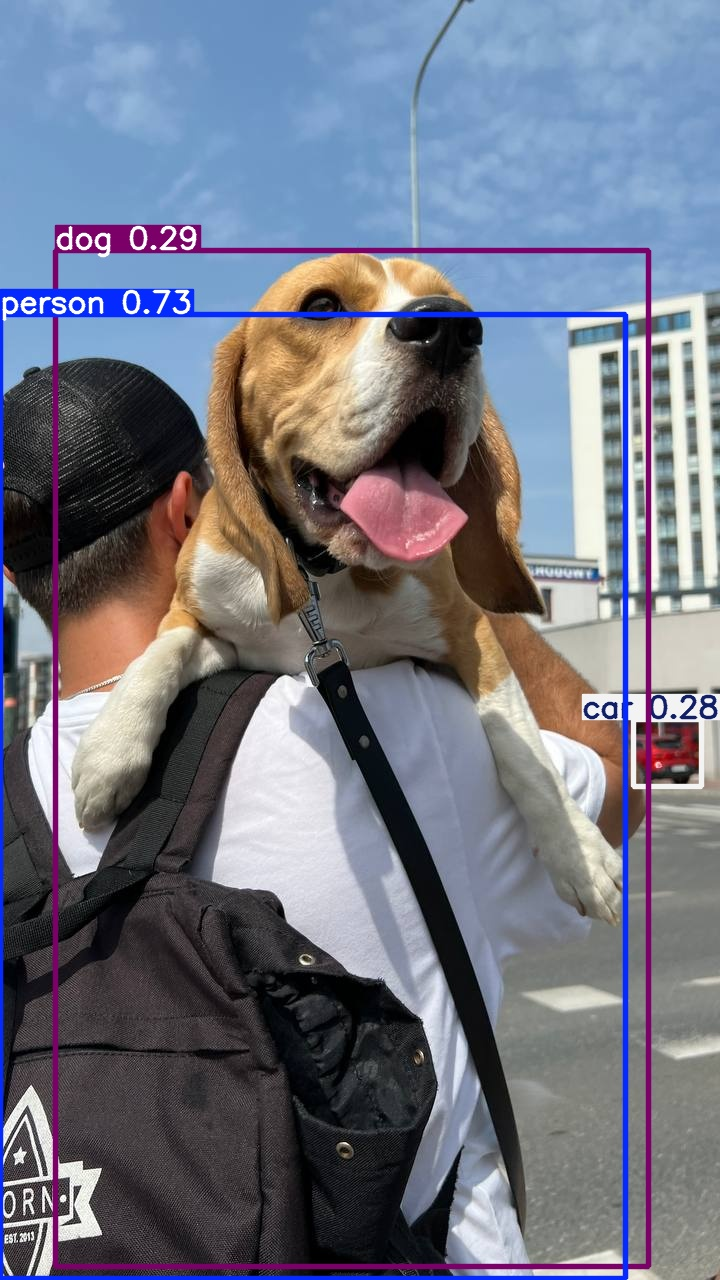

In [7]:
%cd {HOME}
Image(filename='runs/detect/predict/dog.jpeg', height=600)

# on the image, bounding boxes are presented, the label included class of the object and the confidence score

### 🐍 Python SDK

The simplest way of simply using YOLOv8 directly in a Python environment.

In [8]:
model = YOLO(f'{HOME}/yolov8n.pt')
results = model.predict(source='https://media.roboflow.com/notebooks/examples/dog.jpeg', conf=0.25)


Found https://media.roboflow.com/notebooks/examples/dog.jpeg locally at dog.jpeg
image 1/1 /content/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 45.9ms
Speed: 2.5ms preprocess, 45.9ms inference, 596.6ms postprocess per image at shape (1, 3, 640, 384)


In [9]:
results[0].boxes.xyxy # bounding boxes coordinates existed in the image result[0]
# each vector contains 4 value: x_min, y_min (coordinate of the top left corner), x_max, y_max (coordinate of the bottom right corner)

tensor([[   0.0000,  314.4717,  625.0754, 1278.1946],
        [  55.1731,  250.0220,  648.1080, 1266.2720],
        [ 633.2291,  719.5391,  701.0538,  786.0336]], device='cuda:0')

In [10]:
results[0].boxes.conf # confidence scores of detected objects

tensor([0.7271, 0.2907, 0.2846], device='cuda:0')

In [11]:
results[0].boxes.cls # classes of detected objects

tensor([ 0., 16.,  2.], device='cuda:0')

## Custom Training

I will use YOLOv8 model to do object detection on recycle materials

Dataset: https://universe.roboflow.com/4404project/recycle-detection/dataset/9#


In [12]:
%cd {HOME}

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="API_KEY")
project = rf.workspace("4404project").project("recycle-detection")
version = project.version(9)
dataset = version.download("yolov8")


/content
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Recycle-Detection-9 in yolov8:: 100%|██████████| 4914/4914 [00:00<00:00, 9411.63it/s]


In [13]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=25 imgsz=800 plots=True

/content
100% 21.5M/21.5M [00:00<00:00, 262MB/s]
New https://pypi.org/project/ultralytics/8.3.51 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/Recycle-Detection-9/data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=800, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, cla

/content


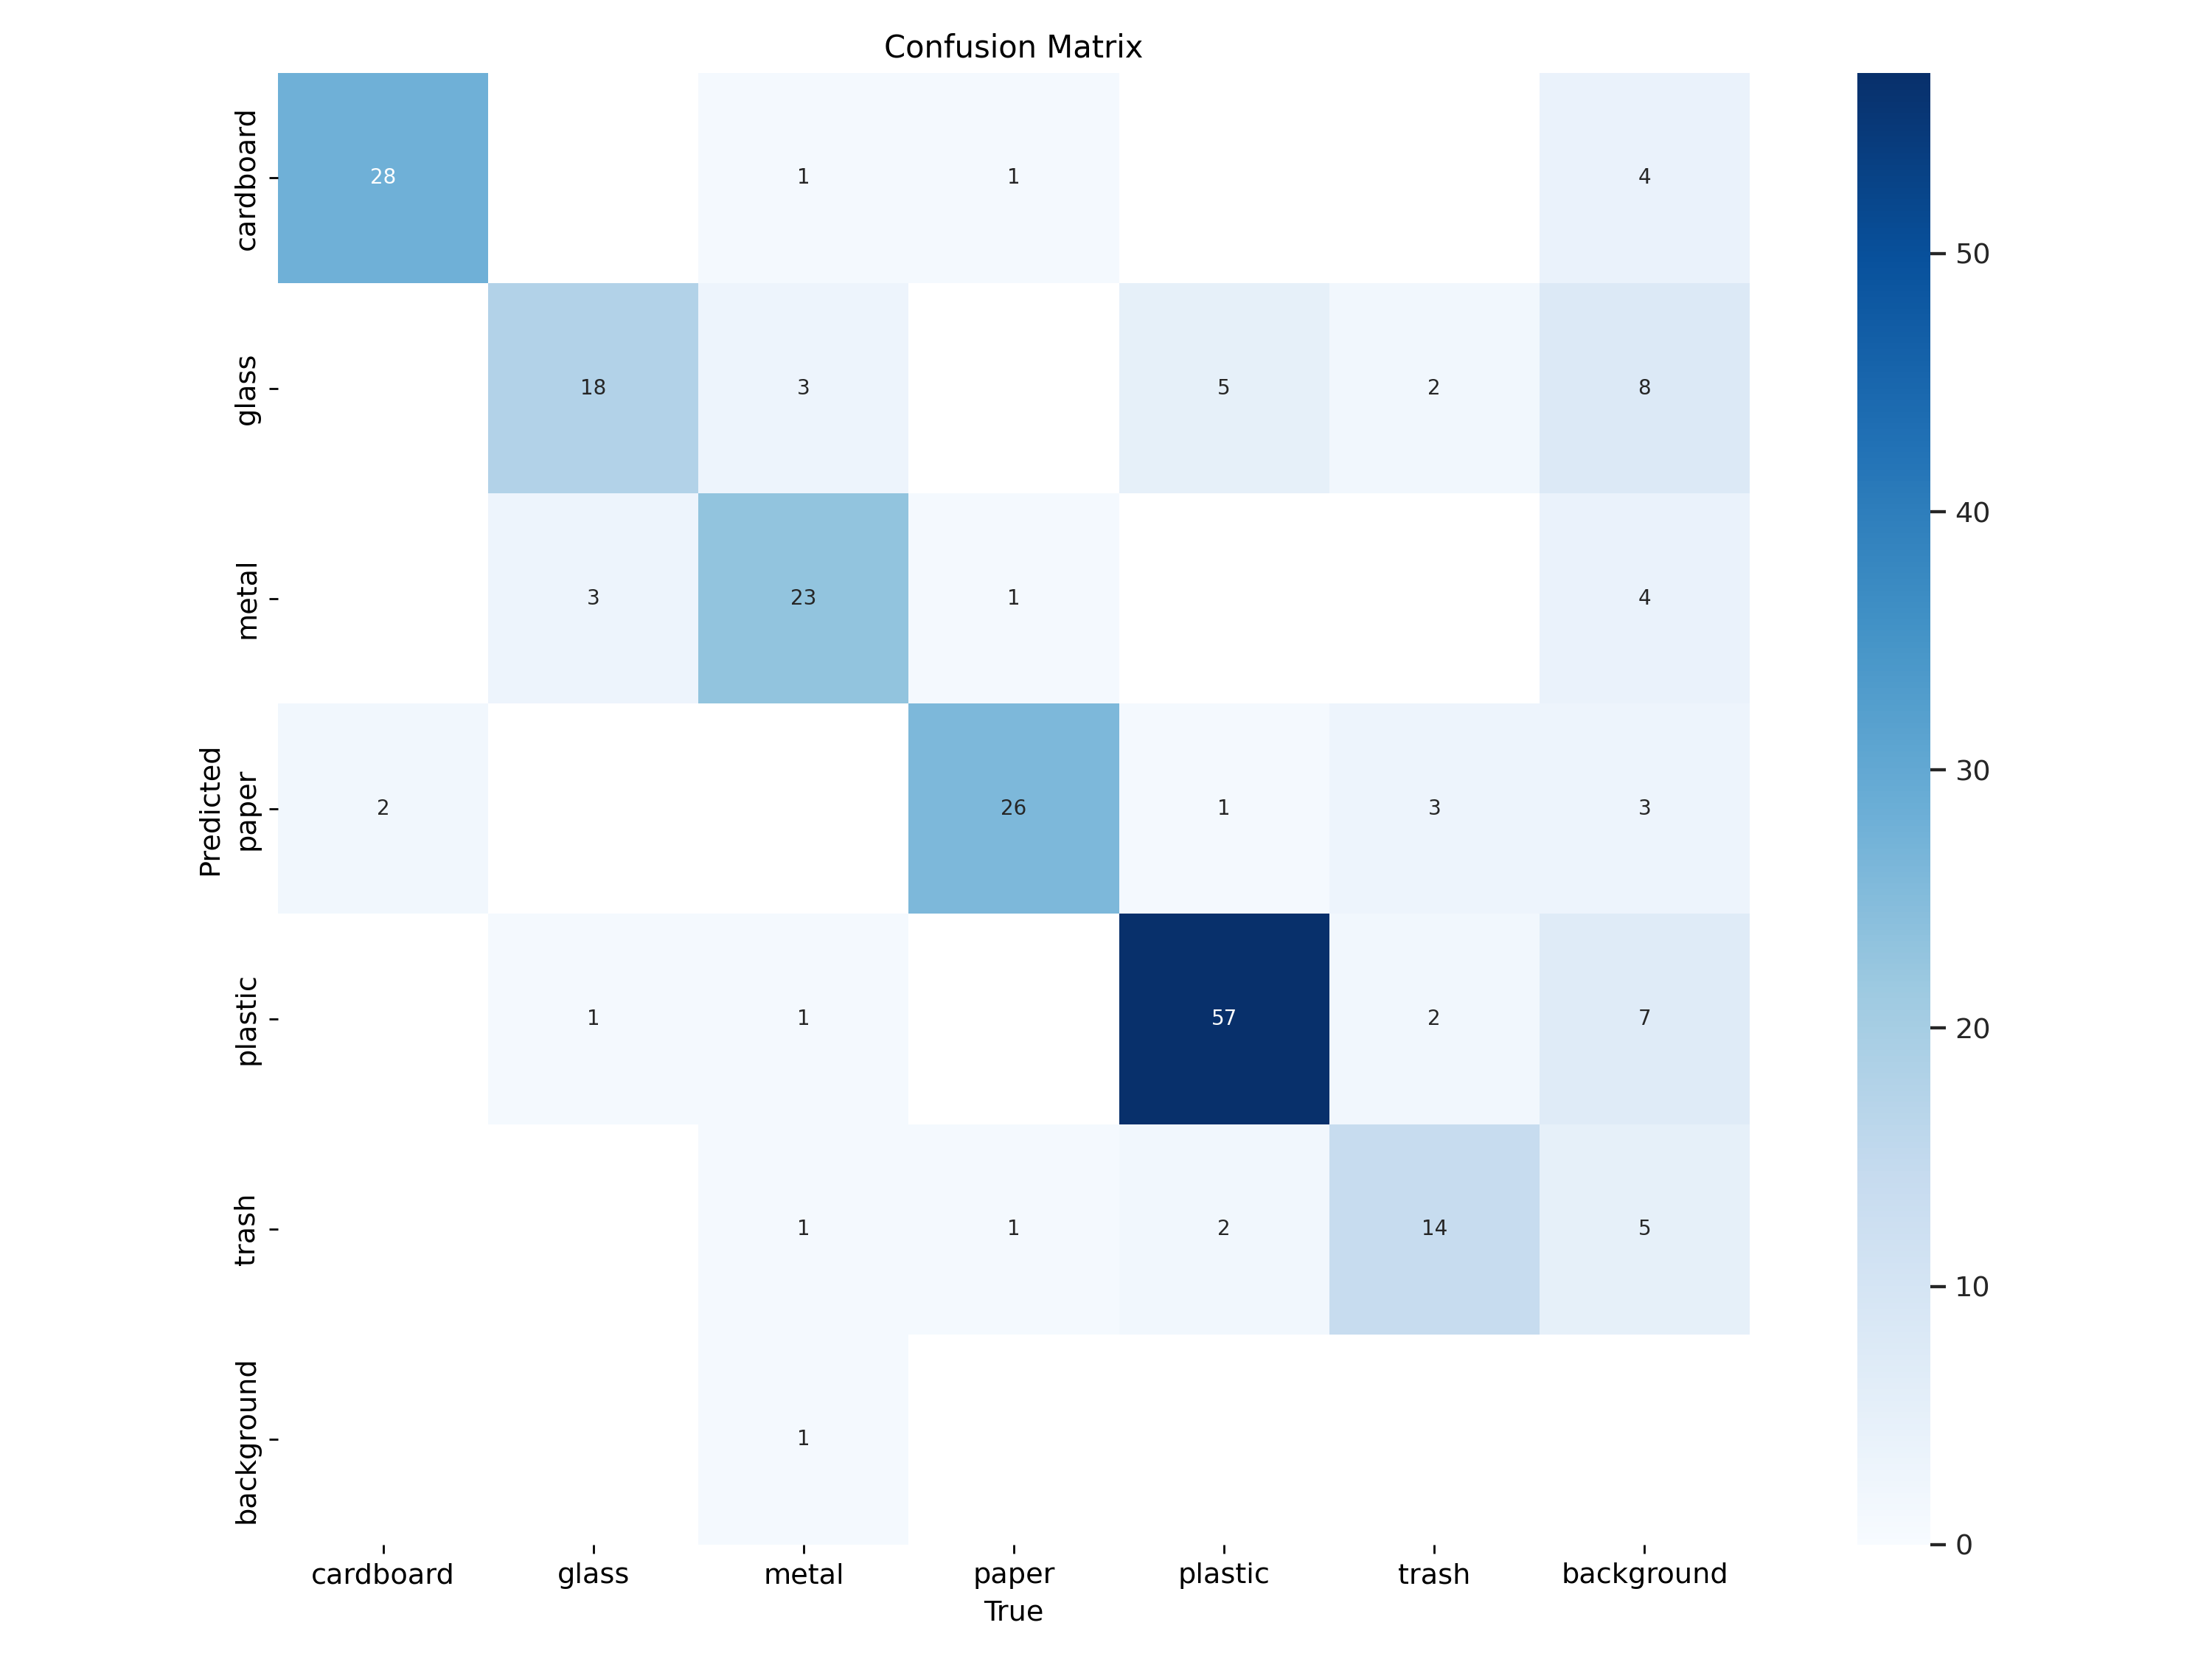

In [15]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=800)

/content


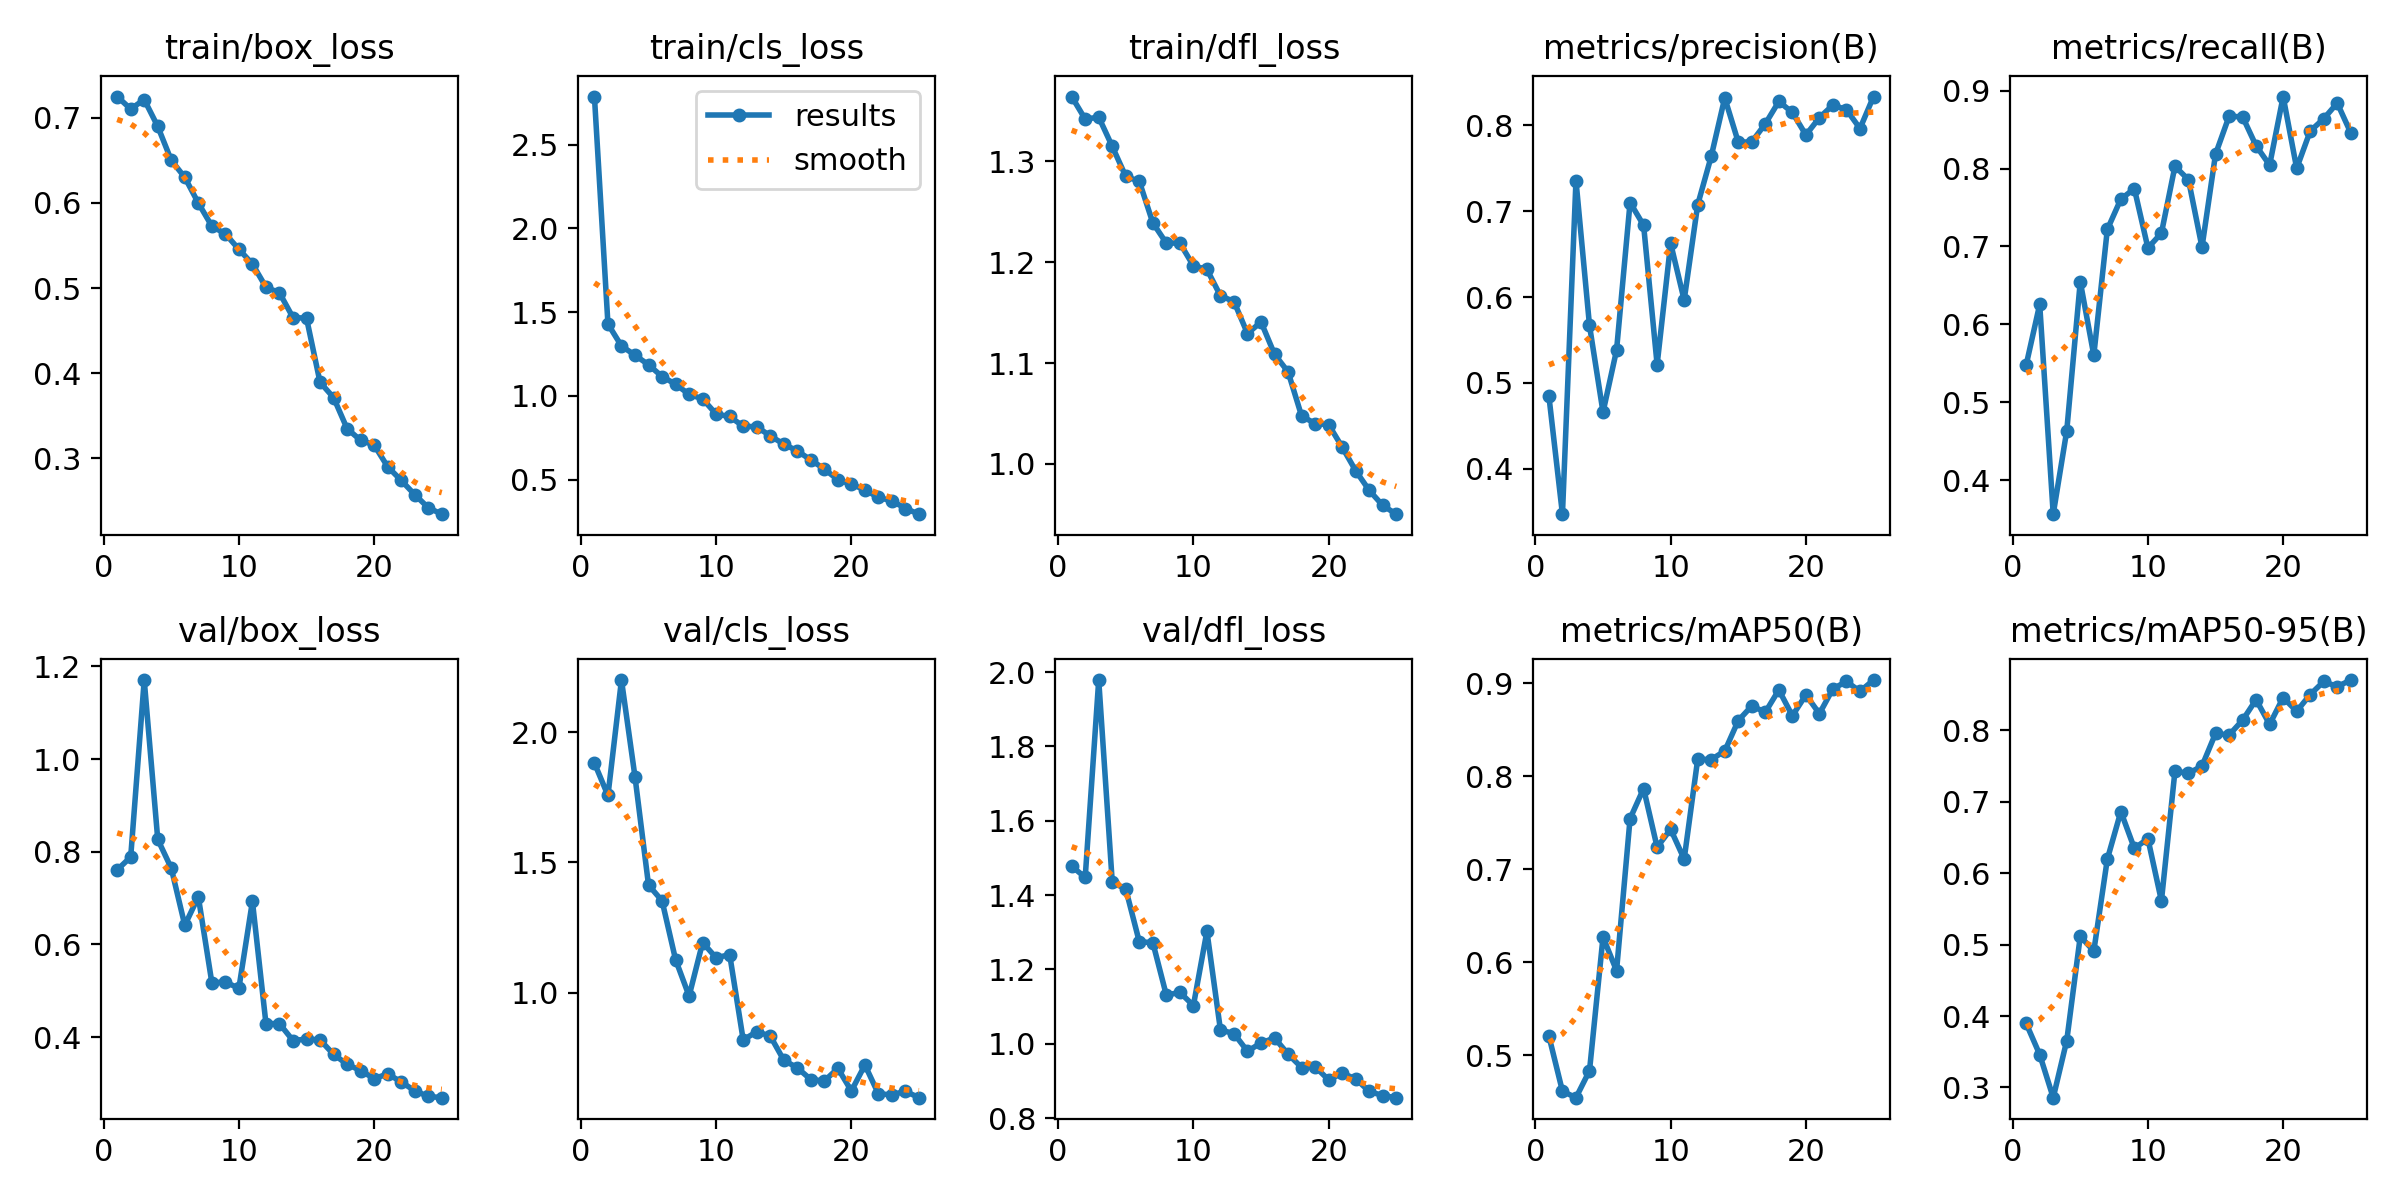

In [17]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=800)

/content


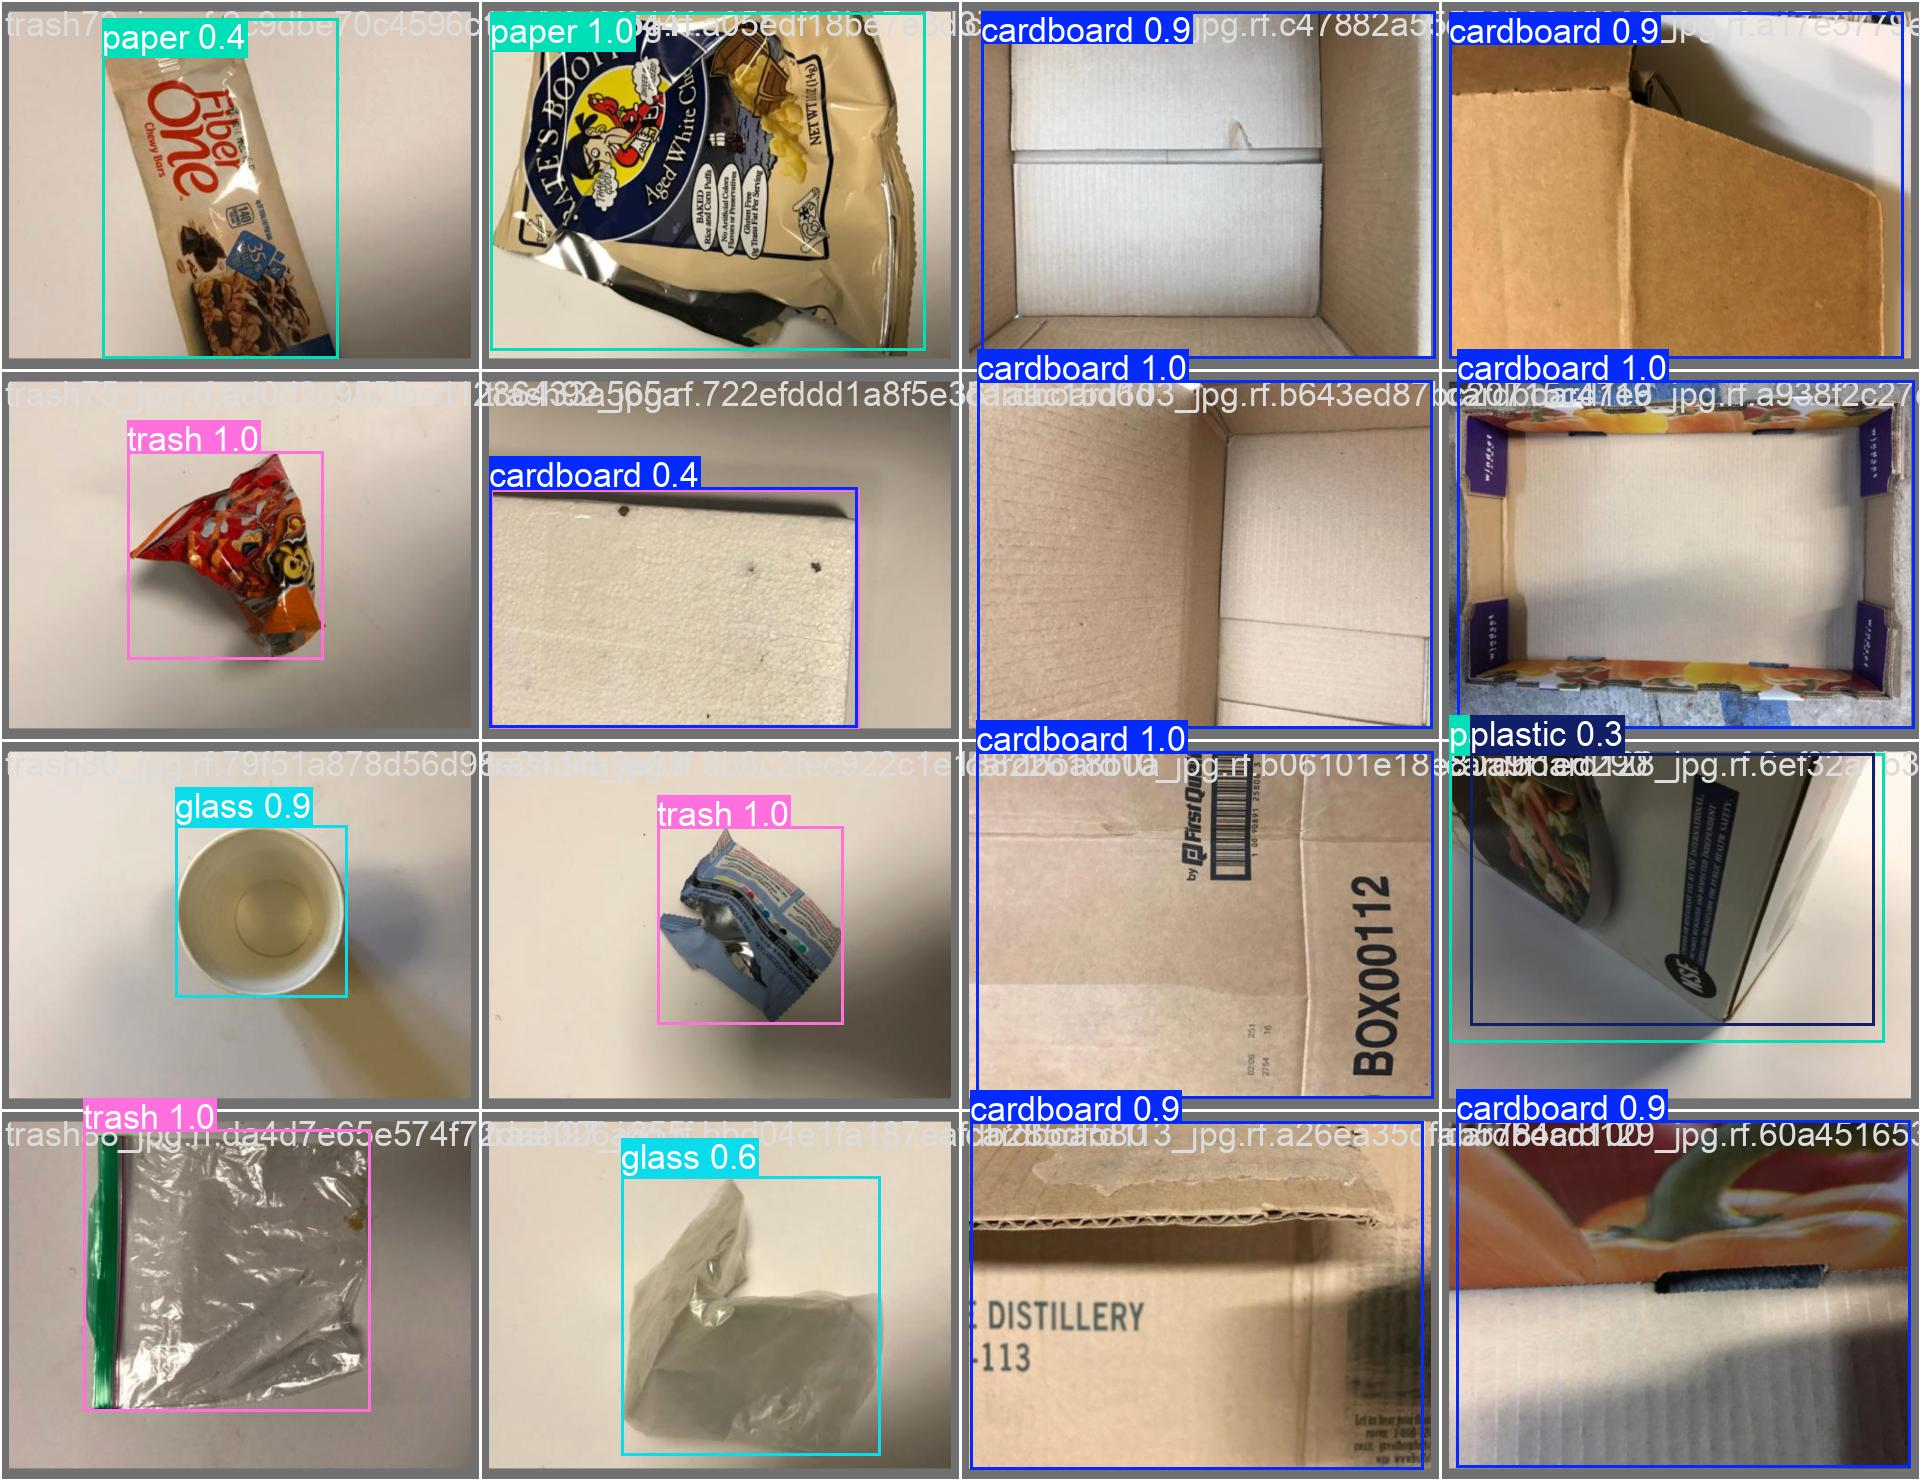

In [18]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate Custom Model

In [19]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

/content
Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/Recycle-Detection-9/valid/labels.cache... 200 images, 3 backgrounds, 0 corrupt: 100% 200/200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 13/13 [00:04<00:00,  2.67it/s]
                   all        200        197      0.833      0.846      0.903       0.87
             cardboard         30         30      0.874      0.967      0.887      0.874
                 glass         22         22      0.694      0.864      0.881       0.83
                 metal         30         30      0.878      0.733      0.914      0.872
                 paper         29         29      0.879      0.897      0.955      0.931
               plastic         65         65      0.917      0.855      0.967      0.931
                 trash     

## Inference with Custom Model

In [20]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

/content
Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs

image 1/133 /content/Recycle-Detection-9/test/images/cardboard108_jpg.rf.20d5b5d047a753f5033a6b4db84d16fe.jpg: 608x800 1 cardboard, 40.3ms
image 2/133 /content/Recycle-Detection-9/test/images/cardboard11_jpg.rf.711fcdbe8e389cece338f94050245e8f.jpg: 608x800 1 cardboard, 18.1ms
image 3/133 /content/Recycle-Detection-9/test/images/cardboard137_jpg.rf.e5a04b770c3bd7f5efebaef86d2fb3b0.jpg: 608x800 1 cardboard, 18.0ms
image 4/133 /content/Recycle-Detection-9/test/images/cardboard145_jpg.rf.c6a5fe84970d616e63d004f73a456944.jpg: 608x800 1 cardboard, 17.9ms
image 5/133 /content/Recycle-Detection-9/test/images/cardboard154_jpg.rf.35c0125ae33be0fbfb17d002d37540e5.jpg: 608x800 1 cardboard, 17.9ms
image 6/133 /content/Recycle-Detection-9/test/images/cardboard162_jpg.rf.e23d8dd3e45474c54fa67b8be0d6422e.jpg: 608x800 1 card

**NOTE:** Let's take a look at few results.

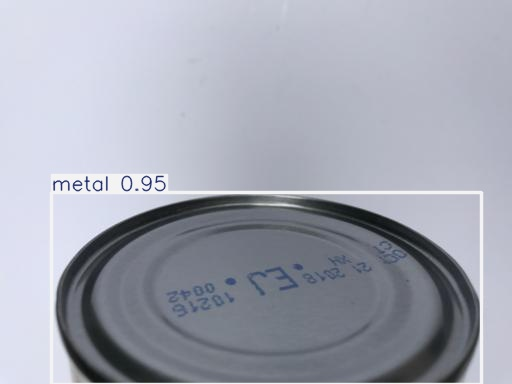

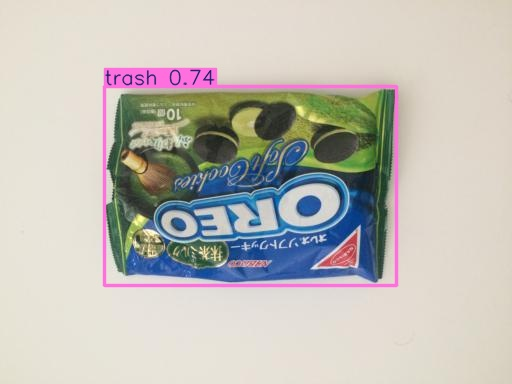

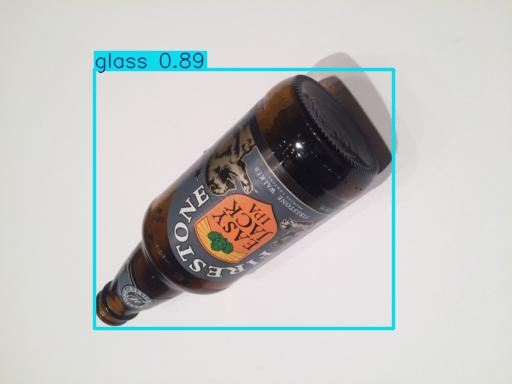

In [21]:
import glob
from IPython.display import Image, display

# Define the base path where the folders are located
base_path = '/content/runs/detect/'

# List all directories that start with 'predict' in the base path
subfolders = [os.path.join(base_path, d) for d in os.listdir(base_path)
              if os.path.isdir(os.path.join(base_path, d)) and d.startswith('predict')]

# Find the latest folder by modification time
latest_folder = max(subfolders, key=os.path.getmtime)

image_paths = glob.glob(f'{latest_folder}/*.jpg')[:3]

# Display each image
for image_path in image_paths:
    display(Image(filename=image_path, width=600))
    print("\n")